# Text summarization
https://www.kaggle.com/snap/amazon-fine-food-reviews  
kaggle에서 찾은 아마존 음식리뷰 데이터

In [130]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import os
np.random.seed(seed=777)

# 1. 데이터 불러오기

In [131]:
data = pd.read_csv("reviews/Reviews.csv", encoding='utf-8')
data.shape

(568454, 10)

In [132]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


실제 텍스트인 'Text'와 label이 될 요약본인 'Summary'만 사용할 것이다

In [133]:
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


# 2. 데이터 전처리 

### 1) 중복 및 Null 제거

In [134]:
print(data['Text'].nunique())
print(data['Summary'].nunique())

393579
295742


원문이 비해 요약의 중복이 많은 것은 다른 내용도 같은 요약일 수 있기 때문?  
전체 리뷰가 약 56만개였는데 중복이 아주 많다.

In [135]:
data.drop_duplicates(subset=['Text'], inplace=True)
data.shape

(393579, 2)

In [136]:
# null 확인
data.isnull().sum()

Text       0
Summary    3
dtype: int64

In [137]:
data.dropna(axis=0, inplace=True)
data.shape

(393576, 2)

### 2) 축약어 원복

In [138]:
# expand contractions
# from wikipedia table
contractions = { 
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he has",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she has",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [139]:
# NLTK stopwords
stop_words = set(stopwords.words('english'))
len(stop_words)

179

In [140]:
# preprocessing!
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()                     # lower case
    sentence = BeautifulSoup(sentence, "lxml").text # remove HTML tags
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # remove parentheses
    sentence = re.sub('"', "", sentence)            # remove ""
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # expand contractions
   # sentence = re.sub(r"s\b", "", sentence)         # remove possesive
    sentence = re.sub(r'[^a-zA-Z]', " ", sentence)     # remove all except english
    sentence = re.sub('[m]{2,}', 'mm', sentence)    # Ex) hmmmmmmmm -> hmm 한국어로 치면 ㅋㅋㅋ 너무많은것 줄이는 것
    
    if remove_stopwords:
        tokens = " ".join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = " ".join(word for word in sentence.split() if len(word) > 1)
        
    return tokens
    

In [141]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [142]:
data['Text'] = data['Text'].apply(preprocess_sentence)
data['Summary'] = data['Summary'].apply(preprocess_sentence)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b000v9lq30/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarn

In [143]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text          3
Summary    1242
dtype: int64


In [144]:
data.dropna(axis = 0, inplace = True)
len(data)

392333

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 1919
텍스트의 평균 길이 : 38.00184027344118
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 2.8498775275085197


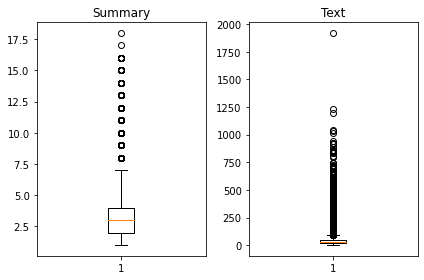

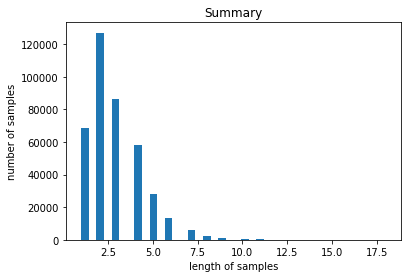

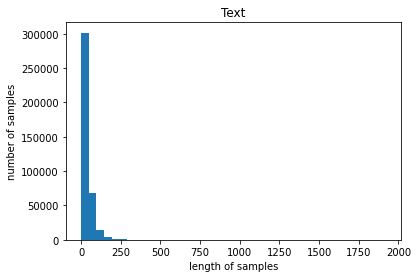

In [145]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [146]:
text_max_len = 80
summary_max_len = 6

In [147]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [148]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 80 이하인 샘플의 비율: 0.913173248235555


In [149]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 6 이하인 샘플의 비율: 0.9734281847308281


In [150]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 350808


### 3) sos, eos token 추가

In [151]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,advertised,sostoken advertised,advertised eostoken
2,confection around centuries light pillowy citr...,delight says,sostoken delight says,delight says eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [152]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# 2. Train/Test Split

In [153]:
# shuffle data
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [154]:
num_vals = int(len(encoder_input)*0.2) # 80:20 split
num_vals

70161

In [155]:
encoder_input_train = encoder_input[:-num_vals]
decoder_input_train = decoder_input[:-num_vals]
decoder_target_train = decoder_target[:-num_vals]

encoder_input_test = encoder_input[-num_vals:]
decoder_input_test = decoder_input[-num_vals:]
decoder_target_test = decoder_target[-num_vals:]

In [156]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 280647
훈련 레이블의 개수 : 280647
테스트 데이터의 개수 : 70161
테스트 레이블의 개수 : 70161


# 3. encoding

In [157]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(encoder_input_train)

In [158]:
threshold = 7
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 85578
등장 빈도가 6번 이하인 희귀 단어의 수: 64722
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20856
단어 집합에서 희귀 단어의 비율: 75.6292505083082
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.340542569713336


unique tokens 중 5번 이하로 나오는 token들은 약 56000개로 토큰의 74%에 해당하지만, 전체 token에서 1%밖에 차지하지 않는다. --> 삭제할 것

### 1) encoder_input encoding

In [159]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [160]:
encoder_input_train[:3]

[[168, 81, 19, 204, 7, 282, 25, 10, 17, 28, 18],
 [3,
  5,
  180,
  151,
  44,
  1473,
  141,
  102,
  41,
  313,
  1281,
  125,
  2062,
  5,
  1440,
  151,
  44,
  180,
  350,
  928,
  71,
  2991,
  2524,
  5,
  1011],
 [19,
  593,
  2269,
  337,
  77,
  33,
  145,
  3,
  356,
  141,
  5,
  2413,
  285,
  14,
  85,
  749,
  16,
  593,
  31,
  692,
  31,
  108,
  1234,
  1321,
  1664,
  134,
  53,
  3197,
  14920]]

### 2) decoder_input encoding

In [161]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 85578
등장 빈도가 5번 이하인 희귀 단어의 수: 63084
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22494
단어 집합에서 희귀 단어의 비율: 73.71520717941526
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.221529621545364


In [162]:
tar_vocab = 19000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [163]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [164]:
decoder_input_train[:5]

[[1, 1886, 1829, 7, 112, 13209],
 [1, 3, 8],
 [1, 32, 1407],
 [1, 391],
 [1, 3, 64, 554, 73, 1738, 22]]

### 3) remove empty samples

In [165]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 1005
삭제할 테스트 데이터의 개수 : 538


### 4) padding

In [166]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 4. Model Training

In [167]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [168]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [169]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [170]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 80, 128)      2304000     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 80, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [171]:
# Download Bahdanau Attention
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [172]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 80, 128)      2304000     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 80, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [173]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [106]:
import tensorflow as tf

In [174]:
checkpoint_path = './checkpoints/possesive/training_checkpoints_{epoch:02d}_poss.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                    save_weights_only=True,
                                    save_best_only=True,
                                    verbose=1)
# Train the model with the new callback

In [176]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es, cp_callback], epochs = 50)

Epoch 1/50
1097/1097 [==============================] - 144s 132ms/step - loss: 2.7443 - accuracy: 0.6049 - val_loss: 2.6442 - val_accuracy: 0.6132

Epoch 00001: val_loss improved from 2.78536 to 2.64425, saving model to ./checkpoints/possesive/training_checkpoints_01_poss.hdf5
Epoch 2/50
1097/1097 [==============================] - 145s 132ms/step - loss: 2.6291 - accuracy: 0.6135 - val_loss: 2.5595 - val_accuracy: 0.6188

Epoch 00002: val_loss improved from 2.64425 to 2.55951, saving model to ./checkpoints/possesive/training_checkpoints_02_poss.hdf5
Epoch 3/50
1097/1097 [==============================] - 145s 132ms/step - loss: 2.5541 - accuracy: 0.6187 - val_loss: 2.5115 - val_accuracy: 0.6204

Epoch 00003: val_loss improved from 2.55951 to 2.51145, saving model to ./checkpoints/possesive/training_checkpoints_03_poss.hdf5
Epoch 4/50
1097/1097 [==============================] - 145s 133ms/step - loss: 2.5019 - accuracy: 0.6226 - val_loss: 2.4715 - val_accuracy: 0.6253

Epoch 00004: v

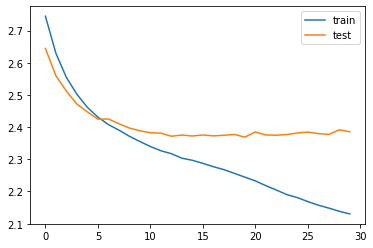

In [179]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

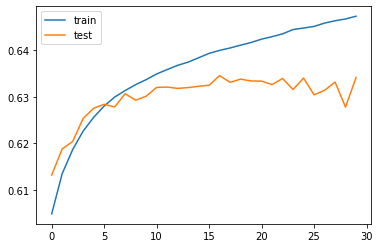

In [180]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [181]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [182]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [183]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [184]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [185]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [186]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  believe actually fell upon brand marshalls never found course searched internet happy find amazon review escargots best ever incredible better restaurants bother even buying local supermarket simply compare hope company continues import escargot recipes never without bon appetite 
실제 요약문 : like france 
예측 요약문 :  best


원문 :  good tasting tea decent price problem really tea probably drink green tea empty stomach sometimes turn green nausea eventually goes away remember drink empty stomach 
실제 요약문 : nice taste 
예측 요약문 :  good tea


원문 :  love tea hot cold cream sugar plain great flavor sachet makes least two tall glasses tea 
실제 요약문 : new favorite iced tea 
예측 요약문 :  great tea


원문 :  tasty bought son interested anything japanese last mouth chewy almost like gum swallow great flavor sweet tart highly recommend price good well pack believe 
실제 요약문 : tasty 
예측 요약문 :  yummy


원문 :  exact brand expensive neighborhood health store oz cost getting great deal taste better butter used ever

In [ ]:
encoder_input_test 